# NLP Sentiment Analysis using TextBlob #

In [3]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import nltk
import re
import string
import emoji
import contractions
import datatable as dt

from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from bs4 import BeautifulSoup
from langdetect import detect
# from googletrans import Translator
from deep_translator import GoogleTranslator
from nltk.corpus import stopwords, wordnet, inaugural
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.probability import FreqDist
from wordcloud import WordCloud
from textblob import TextBlob
from textblob.classifiers import NaiveBayesClassifier

In [4]:
# Load and preview the dataset
df = pd.read_csv('AirBnb_reviews.csv')
df.tail()

,listing_id,id,date,reviewer_id,reviewer_name,comments
342899,40606723.0,6.997740e+17,8/23/2022,199478251,Hugo,Excelente ubicación
342900,40606723.0,6.998450e+17,8/23/2022,168768099,Cerys,"Would definitely recommend. Perfect location, ..."
342901,40606723.0,7.004880e+17,8/24/2022,118306945,Anita,"Hôtel bien situé, personnel d’accueil chaleure..."
342902,40606723.0,7.004940e+17,8/24/2022,403631092,Tos,Sehr freundliche Personal. Vom Hotel aus kann ...
342903,40606723.0,7.005040e+17,8/24/2022,467451204,Laura,L’Hotel2Stay si trova in una posizione molto c...


## EDA & Data Preprocessing ##

In [6]:
# Check the number of rows and columns of the dataset
df.shape

(342904, 6)

In [7]:
# Check for null values
df.isnull().sum()

listing_id        0
id                0
date              0
reviewer_id       0
reviewer_name     0
comments         16
dtype: int64

In [8]:
# Drop all the rows with null values
df.dropna(inplace=True)
df.isnull().sum()

listing_id       0
id               0
date             0
reviewer_id      0
reviewer_name    0
comments         0
dtype: int64

In [9]:
# Check the number of rows after dropping the rows with null values
df.shape

(342888, 6)

In [10]:
# Remove the unnecessary columns and preview the dataset
df = df[['reviewer_name', 'comments']]

# Preview the trimmed dataset
df.head()

,reviewer_name,comments
0,Lam,Daniel is really cool. The place was nice and ...
1,Gregory,If you want the authentic Amsterdam houseboat ...
2,Michael,Unique and luxurious to be sure. I couldn't re...
3,Alice,Daniel is the most amazing host! His place is ...
4,Brian,My wife and I recently stopped in Amsterdam fo...


In [11]:
# Check for any non-text comment
df.sort_values(by='comments', ascending=False)

,reviewer_name,comments
276536,Faleh,🧡
281739,Yuval,🧠💍
327922,政揚,🦍🦍🦍
281629,Yamila,🥰
300161,Sebastian,🤡
...,...,...
61275,Thia (& Barry),"\r<br/> I am reviewing a very unpleasant, un..."
20715,Alexander,\r<br/>\r<br/>2. This apartment is an ideal ch...
68084,Mila,\r<br/>\r<br/>\r<br/>la biennvenida muy simpat...
51816,Judith,\r<br/>\r<br/>\r<br/>We stayed in Lot's flat f...


In [12]:
# Function to convert emojis to words
# def convert_emojis_to_words(text):
#     converted_text = emoji.demojize(text)
#     return converted_text


def convert_emoji(text, emoji_dict=None):
  """
  Converts emojis in text to corresponding words from the dictionary.

  Returns:
      String with emojis replaced by words or empty string.
  """

  # Import emoji library within the function
  import emoji

  if emoji_dict:
    # Replace emojis with words from the dictionary
    for emoji, word in emoji_dict.items():
      text = text.replace(emoji, word)
  else:
    # Remove emojis completely (default behavior of demojize)
    text = emoji.demojize(text)
  return text

# Apply the function to the 'comments' column and insert the converted emojis into a new column 'comments_cleaned'
df['comments_cleaned'] = df['comments'].apply(convert_emoji)

# Apply the function to the 'reviewer_name' column and insert the converted emojis into a new column 'reviewer_name_cleaned'
df['reviewer_name_cleaned'] = df['reviewer_name'].apply(convert_emoji)

In [13]:
df.sort_values(by='comments_cleaned', ascending=False)

,reviewer_name,comments,comments_cleaned,reviewer_name_cleaned
162594,Hitomi,ﾛｹｰｼｮﾝは最高です。<br/>日本人は朝食をしっかり食べますよね。B&Bなら朝食がついて...,ﾛｹｰｼｮﾝは最高です。<br/>日本人は朝食をしっかり食べますよね。B&Bなら朝食がついて...,Hitomi
237848,Yutaka,ﾛｹｰｼｮﾝはよいですが､今まで見たことも無い様な狭くて急な階段がｶﾞﾝです。<br/>年配...,ﾛｹｰｼｮﾝはよいですが､今まで見たことも無い様な狭くて急な階段がｶﾞﾝです。<br/>年配...,Yutaka
276722,齊藤,ﾎﾃﾙの前の公園が大きくて､散歩にちょうどいい。部屋は綺麗に掃除してあります。ﾌﾛﾝﾄ対応も...,ﾎﾃﾙの前の公園が大きくて､散歩にちょうどいい。部屋は綺麗に掃除してあります。ﾌﾛﾝﾄ対応も...,齊藤
226061,響子,ﾎｽﾄはとても親切の方で2匹の犬もとても可愛いです。場所もよく近くにはｽｰﾊﾟｰがたくさんあ...,ﾎｽﾄはとても親切の方で2匹の犬もとても可愛いです。場所もよく近くにはｽｰﾊﾟｰがたくさんあ...,響子
187638,Akiko,ﾎｽﾄはとても親切で<br/>ｽﾃｷな笑顔の持ち主です<br/><br/>返信も早いです<b...,ﾎｽﾄはとても親切で<br/>ｽﾃｷな笑顔の持ち主です<br/><br/>返信も早いです<b...,Akiko
...,...,...,...,...
61275,Thia (& Barry),"\r<br/> I am reviewing a very unpleasant, un...","\r<br/> I am reviewing a very unpleasant, un...",Thia (& Barry)
20715,Alexander,\r<br/>\r<br/>2. This apartment is an ideal ch...,\r<br/>\r<br/>2. This apartment is an ideal ch...,Alexander
68084,Mila,\r<br/>\r<br/>\r<br/>la biennvenida muy simpat...,\r<br/>\r<br/>\r<br/>la biennvenida muy simpat...,Mila
51816,Judith,\r<br/>\r<br/>\r<br/>We stayed in Lot's flat f...,\r<br/>\r<br/>\r<br/>We stayed in Lot's flat f...,Judith


In [14]:
# Removing URLs
df['comments_cleaned'] = df['comments_cleaned'].apply(lambda x: re.sub(r'http\S+|www.\S+', '', x))
df['reviewer_name_cleaned'] = df['reviewer_name_cleaned'].apply(lambda x: re.sub(r'http\S+|www.\S+', '', x))

In [15]:
df.sort_values(by='comments_cleaned', ascending=False)

,reviewer_name,comments,comments_cleaned,reviewer_name_cleaned
162594,Hitomi,ﾛｹｰｼｮﾝは最高です。<br/>日本人は朝食をしっかり食べますよね。B&Bなら朝食がついて...,ﾛｹｰｼｮﾝは最高です。<br/>日本人は朝食をしっかり食べますよね。B&Bなら朝食がついて...,Hitomi
237848,Yutaka,ﾛｹｰｼｮﾝはよいですが､今まで見たことも無い様な狭くて急な階段がｶﾞﾝです。<br/>年配...,ﾛｹｰｼｮﾝはよいですが､今まで見たことも無い様な狭くて急な階段がｶﾞﾝです。<br/>年配...,Yutaka
276722,齊藤,ﾎﾃﾙの前の公園が大きくて､散歩にちょうどいい。部屋は綺麗に掃除してあります。ﾌﾛﾝﾄ対応も...,ﾎﾃﾙの前の公園が大きくて､散歩にちょうどいい。部屋は綺麗に掃除してあります。ﾌﾛﾝﾄ対応も...,齊藤
226061,響子,ﾎｽﾄはとても親切の方で2匹の犬もとても可愛いです。場所もよく近くにはｽｰﾊﾟｰがたくさんあ...,ﾎｽﾄはとても親切の方で2匹の犬もとても可愛いです。場所もよく近くにはｽｰﾊﾟｰがたくさんあ...,響子
187638,Akiko,ﾎｽﾄはとても親切で<br/>ｽﾃｷな笑顔の持ち主です<br/><br/>返信も早いです<b...,ﾎｽﾄはとても親切で<br/>ｽﾃｷな笑顔の持ち主です<br/><br/>返信も早いです<b...,Akiko
...,...,...,...,...
61275,Thia (& Barry),"\r<br/> I am reviewing a very unpleasant, un...","\r<br/> I am reviewing a very unpleasant, un...",Thia (& Barry)
20715,Alexander,\r<br/>\r<br/>2. This apartment is an ideal ch...,\r<br/>\r<br/>2. This apartment is an ideal ch...,Alexander
68084,Mila,\r<br/>\r<br/>\r<br/>la biennvenida muy simpat...,\r<br/>\r<br/>\r<br/>la biennvenida muy simpat...,Mila
51816,Judith,\r<br/>\r<br/>\r<br/>We stayed in Lot's flat f...,\r<br/>\r<br/>\r<br/>We stayed in Lot's flat f...,Judith


In [16]:
# Removing HTML tags
df['comments_cleaned'] = df['comments_cleaned'].apply(lambda x: BeautifulSoup(x, "lxml").text)
df['reviewer_name_cleaned'] = df['reviewer_name_cleaned'].apply(lambda x: BeautifulSoup(x, "lxml").text)

C:\Users\Daniel\AppData\Local\Temp\ipykernel_41524\3813491045.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  df['comments_cleaned'] = df['comments_cleaned'].apply(lambda x: BeautifulSoup(x, "lxml").text)
C:\Users\Daniel\AppData\Local\Temp\ipykernel_41524\3813491045.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  df['reviewer_name_cleaned'] = df['reviewer_name_cleaned'].apply(lambda x: BeautifulSoup(x, "lxml").text)


In [17]:
df.sort_values(by='comments_cleaned', ascending=False)

,reviewer_name,comments,comments_cleaned,reviewer_name_cleaned
162594,Hitomi,ﾛｹｰｼｮﾝは最高です。<br/>日本人は朝食をしっかり食べますよね。B&Bなら朝食がついて...,ﾛｹｰｼｮﾝは最高です。日本人は朝食をしっかり食べますよね。B&Bなら朝食がついているかと思...,Hitomi
237848,Yutaka,ﾛｹｰｼｮﾝはよいですが､今まで見たことも無い様な狭くて急な階段がｶﾞﾝです。<br/>年配...,ﾛｹｰｼｮﾝはよいですが､今まで見たことも無い様な狭くて急な階段がｶﾞﾝです。年配者や酔っ払...,Yutaka
276722,齊藤,ﾎﾃﾙの前の公園が大きくて､散歩にちょうどいい。部屋は綺麗に掃除してあります。ﾌﾛﾝﾄ対応も...,ﾎﾃﾙの前の公園が大きくて､散歩にちょうどいい。部屋は綺麗に掃除してあります。ﾌﾛﾝﾄ対応も...,齊藤
226061,響子,ﾎｽﾄはとても親切の方で2匹の犬もとても可愛いです。場所もよく近くにはｽｰﾊﾟｰがたくさんあ...,ﾎｽﾄはとても親切の方で2匹の犬もとても可愛いです。場所もよく近くにはｽｰﾊﾟｰがたくさんあ...,響子
187638,Akiko,ﾎｽﾄはとても親切で<br/>ｽﾃｷな笑顔の持ち主です<br/><br/>返信も早いです<b...,ﾎｽﾄはとても親切でｽﾃｷな笑顔の持ち主です返信も早いですお部屋もとても清潔で冬はとても暖か...,Akiko
...,...,...,...,...
51816,Judith,\r<br/>\r<br/>\r<br/>We stayed in Lot's flat f...,We stayed in Lot's flat for 6 days and enjoy...,Judith
47219,Loïc,\r<br/>\r<br/>\r<br/>\r<br/>Very nice trip in...,Very nice trip in Amsterdam! Thanks to Eva'...,Loïc
61275,Thia (& Barry),"\r<br/> I am reviewing a very unpleasant, un...","I am reviewing a very unpleasant, unprofess...",Thia (& Barry)
115308,Delphine,\r<br/>\r<br/>\r<br/>\r<br/>\r<br/>\r<br/>\r<b...,Apartment very nice...,Delphine


In [18]:
# Removing punctuation
df['comments_cleaned'] = df['comments_cleaned'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
df['reviewer_name_cleaned'] = df['reviewer_name_cleaned'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

In [19]:
df.sort_values(by='comments_cleaned', ascending=False)

,reviewer_name,comments,comments_cleaned,reviewer_name_cleaned
162594,Hitomi,ﾛｹｰｼｮﾝは最高です。<br/>日本人は朝食をしっかり食べますよね。B&Bなら朝食がついて...,ﾛｹｰｼｮﾝは最高です。日本人は朝食をしっかり食べますよね。BBなら朝食がついているかと思っ...,Hitomi
237848,Yutaka,ﾛｹｰｼｮﾝはよいですが､今まで見たことも無い様な狭くて急な階段がｶﾞﾝです。<br/>年配...,ﾛｹｰｼｮﾝはよいですが､今まで見たことも無い様な狭くて急な階段がｶﾞﾝです。年配者や酔っ払...,Yutaka
276722,齊藤,ﾎﾃﾙの前の公園が大きくて､散歩にちょうどいい。部屋は綺麗に掃除してあります。ﾌﾛﾝﾄ対応も...,ﾎﾃﾙの前の公園が大きくて､散歩にちょうどいい。部屋は綺麗に掃除してあります。ﾌﾛﾝﾄ対応も...,齊藤
226061,響子,ﾎｽﾄはとても親切の方で2匹の犬もとても可愛いです。場所もよく近くにはｽｰﾊﾟｰがたくさんあ...,ﾎｽﾄはとても親切の方で2匹の犬もとても可愛いです。場所もよく近くにはｽｰﾊﾟｰがたくさんあ...,響子
187638,Akiko,ﾎｽﾄはとても親切で<br/>ｽﾃｷな笑顔の持ち主です<br/><br/>返信も早いです<b...,ﾎｽﾄはとても親切でｽﾃｷな笑顔の持ち主です返信も早いですお部屋もとても清潔で冬はとても暖か...,Akiko
...,...,...,...,...
321175,Antoinette,-,,Antoinette
317249,Luca Carlo,.,,Luca Carlo
285272,Iris,.,,Iris
22170,Derek,.,,Derek


In [20]:
# Removing numbers
df['comments_cleaned'] = df['comments_cleaned'].apply(lambda x: re.sub(r'\d+', '', x))
df['reviewer_name_cleaned'] = df['reviewer_name_cleaned'].apply(lambda x: re.sub(r'\d+', '', x))

In [21]:
df.sort_values(by='comments_cleaned', ascending=False)

,reviewer_name,comments,comments_cleaned,reviewer_name_cleaned
162594,Hitomi,ﾛｹｰｼｮﾝは最高です。<br/>日本人は朝食をしっかり食べますよね。B&Bなら朝食がついて...,ﾛｹｰｼｮﾝは最高です。日本人は朝食をしっかり食べますよね。BBなら朝食がついているかと思っ...,Hitomi
237848,Yutaka,ﾛｹｰｼｮﾝはよいですが､今まで見たことも無い様な狭くて急な階段がｶﾞﾝです。<br/>年配...,ﾛｹｰｼｮﾝはよいですが､今まで見たことも無い様な狭くて急な階段がｶﾞﾝです。年配者や酔っ払...,Yutaka
276722,齊藤,ﾎﾃﾙの前の公園が大きくて､散歩にちょうどいい。部屋は綺麗に掃除してあります。ﾌﾛﾝﾄ対応も...,ﾎﾃﾙの前の公園が大きくて､散歩にちょうどいい。部屋は綺麗に掃除してあります。ﾌﾛﾝﾄ対応も...,齊藤
226061,響子,ﾎｽﾄはとても親切の方で2匹の犬もとても可愛いです。場所もよく近くにはｽｰﾊﾟｰがたくさんあ...,ﾎｽﾄはとても親切の方で匹の犬もとても可愛いです。場所もよく近くにはｽｰﾊﾟｰがたくさんあり...,響子
187638,Akiko,ﾎｽﾄはとても親切で<br/>ｽﾃｷな笑顔の持ち主です<br/><br/>返信も早いです<b...,ﾎｽﾄはとても親切でｽﾃｷな笑顔の持ち主です返信も早いですお部屋もとても清潔で冬はとても暖か...,Akiko
...,...,...,...,...
310928,Thomas,.,,Thomas
62031,Jodi,.,,Jodi
335196,فهد,.,,فهد
318868,Hauke,?,,Hauke


In [22]:
# Removing extra spaces
df['comments_cleaned'] = df['comments_cleaned'].apply(lambda x: ' '.join(x.split()))
df['reviewer_name_cleaned'] = df['reviewer_name_cleaned'].apply(lambda x: ' '.join(x.split()))

In [23]:
df.sort_values(by='comments_cleaned', ascending=False)

,reviewer_name,comments,comments_cleaned,reviewer_name_cleaned
162594,Hitomi,ﾛｹｰｼｮﾝは最高です。<br/>日本人は朝食をしっかり食べますよね。B&Bなら朝食がついて...,ﾛｹｰｼｮﾝは最高です。日本人は朝食をしっかり食べますよね。BBなら朝食がついているかと思っ...,Hitomi
237848,Yutaka,ﾛｹｰｼｮﾝはよいですが､今まで見たことも無い様な狭くて急な階段がｶﾞﾝです。<br/>年配...,ﾛｹｰｼｮﾝはよいですが､今まで見たことも無い様な狭くて急な階段がｶﾞﾝです。年配者や酔っ払...,Yutaka
276722,齊藤,ﾎﾃﾙの前の公園が大きくて､散歩にちょうどいい。部屋は綺麗に掃除してあります。ﾌﾛﾝﾄ対応も...,ﾎﾃﾙの前の公園が大きくて､散歩にちょうどいい。部屋は綺麗に掃除してあります。ﾌﾛﾝﾄ対応も...,齊藤
226061,響子,ﾎｽﾄはとても親切の方で2匹の犬もとても可愛いです。場所もよく近くにはｽｰﾊﾟｰがたくさんあ...,ﾎｽﾄはとても親切の方で匹の犬もとても可愛いです。場所もよく近くにはｽｰﾊﾟｰがたくさんあり...,響子
187638,Akiko,ﾎｽﾄはとても親切で<br/>ｽﾃｷな笑顔の持ち主です<br/><br/>返信も早いです<b...,ﾎｽﾄはとても親切でｽﾃｷな笑顔の持ち主です返信も早いですお部屋もとても清潔で冬はとても暖か...,Akiko
...,...,...,...,...
197484,Marc And Angelica,..,,Marc And Angelica
208708,Cem,.,,Cem
293663,Javo,.,,Javo
291342,Riccardo,.,,Riccardo


In [24]:
# Replacing repetitions of punctuation
df['comments_cleaned'] = df['comments_cleaned'].apply(lambda x: re.sub(r'(\W)\1+', r'\1', x))
df['reviewer_name_cleaned'] = df['reviewer_name_cleaned'].apply(lambda x: re.sub(r'(\W)\1+', r'\1', x))

In [25]:
df.sort_values(by='comments_cleaned', ascending=False)

,reviewer_name,comments,comments_cleaned,reviewer_name_cleaned
162594,Hitomi,ﾛｹｰｼｮﾝは最高です。<br/>日本人は朝食をしっかり食べますよね。B&Bなら朝食がついて...,ﾛｹｰｼｮﾝは最高です。日本人は朝食をしっかり食べますよね。BBなら朝食がついているかと思っ...,Hitomi
237848,Yutaka,ﾛｹｰｼｮﾝはよいですが､今まで見たことも無い様な狭くて急な階段がｶﾞﾝです。<br/>年配...,ﾛｹｰｼｮﾝはよいですが､今まで見たことも無い様な狭くて急な階段がｶﾞﾝです。年配者や酔っ払...,Yutaka
276722,齊藤,ﾎﾃﾙの前の公園が大きくて､散歩にちょうどいい。部屋は綺麗に掃除してあります。ﾌﾛﾝﾄ対応も...,ﾎﾃﾙの前の公園が大きくて､散歩にちょうどいい。部屋は綺麗に掃除してあります。ﾌﾛﾝﾄ対応も...,齊藤
226061,響子,ﾎｽﾄはとても親切の方で2匹の犬もとても可愛いです。場所もよく近くにはｽｰﾊﾟｰがたくさんあ...,ﾎｽﾄはとても親切の方で匹の犬もとても可愛いです。場所もよく近くにはｽｰﾊﾟｰがたくさんあり...,響子
187638,Akiko,ﾎｽﾄはとても親切で<br/>ｽﾃｷな笑顔の持ち主です<br/><br/>返信も早いです<b...,ﾎｽﾄはとても親切でｽﾃｷな笑顔の持ち主です返信も早いですお部屋もとても清潔で冬はとても暖か...,Akiko
...,...,...,...,...
197484,Marc And Angelica,..,,Marc And Angelica
208708,Cem,.,,Cem
293663,Javo,.,,Javo
291342,Riccardo,.,,Riccardo


In [26]:
# Removing special characters
df['comments_cleaned'] = df['comments_cleaned'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))
df['reviewer_name_cleaned'] = df['reviewer_name_cleaned'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))

In [27]:
df.sort_values(by='comments_cleaned', ascending=False)

,reviewer_name,comments,comments_cleaned,reviewer_name_cleaned
19031,Andrea,- zuverlässiger Gastgeber<br/>- alles vor Ort ...,zuverlssiger Gastgeber alles vor Ort wie in de...,Andrea
241718,Weidong,房间很宽敞，采光也很好，位于顶楼，周边交通便利，步行十几分钟就可到达地铁站，可乘坐52路前往...,zuidtramKevin,Weidong
341079,Ezzeddine,"1000 % zu empfehlen<br/>Für jung und alt, mit...",zu empfehlenFr jung und alt mit und ohne Kinde...,Ezzeddine
319819,Christian,zu empfehlen 30 minuten von Amsterdam<br/>mit ...,zu empfehlen minuten von Amsterdammit der tram...,Christian
125376,Paula,zu empfehlen,zu empfehlen,Paula
...,...,...,...,...
321004,Rolf,-,,Rolf
265247,Charlotte Wilhelmina,.,,Charlotte Wilhelmina
230364,מעין,...,,
276417,成英,ここのﾎﾃﾙは予約変更が出来たと言ったのに､次の日になると予約変更出来てないと言われて無理や...,,


In [28]:
# Removing contractions
df['comments_cleaned'] = df['comments_cleaned'].apply(lambda x: contractions.fix(x))
df['reviewer_name_cleaned'] = df['reviewer_name_cleaned'].apply(lambda x: contractions.fix(x))

In [29]:
df.sort_values(by='comments_cleaned', ascending=False)

,reviewer_name,comments,comments_cleaned,reviewer_name_cleaned
19031,Andrea,- zuverlässiger Gastgeber<br/>- alles vor Ort ...,zuverlssiger Gastgeber alles vor Ort wie in de...,Andrea
241718,Weidong,房间很宽敞，采光也很好，位于顶楼，周边交通便利，步行十几分钟就可到达地铁站，可乘坐52路前往...,zuidtramKevin,Weidong
341079,Ezzeddine,"1000 % zu empfehlen<br/>Für jung und alt, mit...",zu empfehlenFr jung und alt mit und ohne Kinde...,Ezzeddine
319819,Christian,zu empfehlen 30 minuten von Amsterdam<br/>mit ...,zu empfehlen minuten von Amsterdammit der tram...,Christian
125376,Paula,zu empfehlen,zu empfehlen,Paula
...,...,...,...,...
233974,Sidsel,.,,Sidsel
262373,Marie,-,,Marie
226541,Jing,房子真的是一尘不染，比照片看上去还要好，还有免费停车，就是距离地铁站大概1公里稍微远了些~欧...,,Jing
70301,佩萱,超棒的房東<br/>很親切，東西不見還幫我們找<br/>推推,,


In [30]:
# Lowercase the data
df['comments_cleaned'] = df['comments_cleaned'].apply(lambda x: x.lower())
df['reviewer_name_cleaned'] = df['reviewer_name_cleaned'].apply(lambda x: x.lower())

In [31]:
# A glance at the dataset after come cleaning
df.sort_values(by='comments_cleaned', ascending=False)

,reviewer_name,comments,comments_cleaned,reviewer_name_cleaned
338150,Lucas,Zxvc,zxvc,lucas
212024,Mona,"Zwei wunderbare helle, saubere Zimmer in super...",zwei wunderbare helle saubere zimmer in super ...,mona
35678,Eric,Zwei unvergleichliche Tage voller wunderbarer ...,zwei unvergleichliche tage voller wunderbarer ...,eric
246996,Gerd,Zwei sehr schöne Doppelzimmer mit einer - bei ...,zwei sehr schne doppelzimmer mit einer bei sch...,gerd
273050,Andreas,Zwei Schlafzimmer sind super und temperierbar....,zwei schlafzimmer sind super und temperierbar ...,andreas
...,...,...,...,...
45399,兰,很好的位置，很周到的房东，很优惠的价格,,
247891,Melina,:),,melina
51683,田添,素敵なご家族でした。息子さんの絵も貼ってあり､ｱｯﾄﾎｰﾑな空間でした。程よく都会から離れて...,,
129191,晶晶,房东老爷爷很热情，离市区还算方便，房间较小，有蚊子，建议放些驱蚊水。,,


### non-English Text ###

The dataset consists of non-English names and comments. We have two methods to deal with them, either remove them or translate them.

#### a. Text Removal ####

In [35]:
# Remove non-English words in 'comments'
# ************************************************

# Iterate through each row
for index, row in df.iterrows():
    text = row['comments']
    try:
        lang = detect(text)
    except:
        lang = 'unknown'
    if lang != 'en':
        df.at[index, 'comments_cleaned'] = ''  # Replace non-English text with an empty string

In [36]:
# Remove non-English words in 'reviewer_name'
# *****************************************************

# Iterate through each row
for index, row in df.iterrows():
    text = row['reviewer_name']
    try:
        lang = detect(text)
    except:
        lang = 'unknown'
    if lang != 'en':
        df.at[index, 'reviewer_name_cleaned'] = ''  # Replace non-English name with an empty string

In [37]:
# Check for null values in the dataset after removing the non-English text
df.isnull().sum()

reviewer_name            0
comments                 0
comments_cleaned         0
reviewer_name_cleaned    0
dtype: int64

#### b. Text Translation ####

Text translation can be done on non-English words into English words with the following code. However, due to my PC hardware limitation (I don't even have a GPU on my laptop), performing translation is going to take a very long time for both of the dataset's columns, 'comments_cleaned' and 'reviewer_name_cleaned'. I have tried run up to 890 minutes for one column and it was not finished, hence I have to stop running it. Hence, I just leave the code here and you are welcome to run the codes if you have a higher specs PC to perform this task.

**NOTE**: disable (comment out) 'Text Removal' code above if you wish to use the translation method.

In [40]:
# # Define the columns containing the text to translate
# comments_en = df['comments_cleaned']
# reviewer_name_en = df['reviewer_name_cleaned']

In [41]:
# # Create a new column for translated text
# df["comments_en"] = None
# df["reviewer_name_en"] = None

In [42]:
# # Initialize the translator
# translator = Translator()

In [43]:
# # Function to translate text (handles potential errors)
# def translate_text(text):
#   try:
#     # Detect source language automatically
#     translation = translator.translate(text, dest="en")
#     return translation.text
#   except Exception:
#     # Handle translation errors (e.g., network issues)
#     return ""

In [44]:
# # Apply translation to each row of 'comments_cleaned' column using vectorized function (faster)
# df["comments_en"] = df['comments_cleaned'].apply(translate_text)

In [45]:
# # Apply translation to each row of 'reviewer_name_cleaned' column using vectorized function (faster)
# df["reviewer_name_en"] = df['reviewer_name_cleaned'].apply(translate_text)

### Further Preprocessing ###

After cleaning the non-English text part, we now export the dataframe to a new .csv file. Then we further preprocess the data of the new dataset.

In [48]:
# Export the updated dataframe
df.to_csv('data.csv', index=False)

# Load the new dataset
clean_df = pd.read_csv('data.csv')

# Preview the new dataset
clean_df.sort_values(by='comments_cleaned', ascending=False)

,reviewer_name,comments,comments_cleaned,reviewer_name_cleaned
121657,Felix,Zora's place was amazing. Very homey and Zora...,zoras place was amazing very homey and zora da...,NaN
121778,Jeremy,Zora’s place was a great- in a cute neighborho...,zoras place was a great in a cute neighborhood...,NaN
121651,Magdalena,"Zora's place is very homely, and full of light...",zoras place is very homely and full of light i...,NaN
121756,Angie,"Zora's place is clean, however the apartment i...",zoras place is clean however the apartment is ...,NaN
121597,Katherine,"Zora's home was wonderful, and she was an even...",zoras home was wonderful and she was an even b...,NaN
...,...,...,...,...
342875,Anna,"Ottimo rapporto qualità-prezzo, l’hotel è a un...",NaN,NaN
342883,Hugo,Excelente ubicación,NaN,NaN
342885,Anita,"Hôtel bien situé, personnel d’accueil chaleure...",NaN,NaN
342886,Tos,Sehr freundliche Personal. Vom Hotel aus kann ...,NaN,tos


In [49]:
# Check if the index has been reset
clean_df.head()

,reviewer_name,comments,comments_cleaned,reviewer_name_cleaned
0,Lam,Daniel is really cool. The place was nice and ...,daniel is really cool the place was nice and c...,NaN
1,Gregory,If you want the authentic Amsterdam houseboat ...,if you want the authentic amsterdam houseboat ...,NaN
2,Michael,Unique and luxurious to be sure. I couldn't re...,unique and luxurious to be sure i could not re...,NaN
3,Alice,Daniel is the most amazing host! His place is ...,daniel is the most amazing host his place is e...,NaN
4,Brian,My wife and I recently stopped in Amsterdam fo...,my wife and i recently stopped in amsterdam fo...,NaN


In [50]:
# Drop all null values in the new dataset
clean_df.dropna(inplace=True)
clean_df.head(20)

,reviewer_name,comments,comments_cleaned,reviewer_name_cleaned
17,Kevin And Nicky,The Houseboat was truly fabulous. A great loca...,the houseboat was truly fabulous a great locat...,kevin and nicky
20,Mathilde,The location is perfect and the boat is perfec...,the location is perfect and the boat is perfec...,mathilde
22,Emily,We had such a lovely warm and comfortable stay...,we had such a lovely warm and comfortable stay...,emily
28,Jessica,Staying on the houseboat was one of the highli...,staying on the houseboat was one of the highli...,jessica
36,Matthias,Great place to stay and discover the city. Esp...,great place to stay and discover the city espe...,matthias
40,Christopher,Location and setting truly can't be beat. Had ...,location and setting truly cannot be beat had ...,christopher
77,Thad,Daan's Houseboat was a treat to stay on. Not o...,daans houseboat was a treat to stay on not onl...,thad
79,Chris,Daan was a great host - helpful and very frien...,daan was a great host helpful and very friendl...,chris
82,Sinead,Myself and three friends stayed on Daan's boat...,myself and three friends stayed on daans boat ...,sinead
84,Cristina,Thanks Daan for making us welcome! Staying in ...,thanks daan for making us welcome staying in a...,cristina


In [51]:
# Check the dataframe size after removing null values
clean_df.shape

(28944, 4)

In [52]:
# Reset the dataset index to start from 0
clean_df.reset_index(drop=True, inplace=True)

In [53]:
# Tokenization for 'comments_cleaned' and 'reviewer_name_cleaned' columns
clean_df['comments_tokens'] = clean_df['comments_cleaned'].apply(lambda x: word_tokenize(x))
clean_df['reviewer_name_tokens'] = clean_df['reviewer_name_cleaned'].apply(lambda x: word_tokenize(x))

In [54]:
# Removing stopwords in the 'comments_cleaned' and 'reviewer_name_cleaned' columns
stop_words = set(stopwords.words('english'))
clean_df['comments_tokens'] = clean_df['comments_tokens'].apply(lambda x: [word for word in x if word not in stop_words])
clean_df['reviewer_name_tokens'] = clean_df['reviewer_name_tokens'].apply(lambda x: [word for word in x if word not in stop_words])

In [55]:
# Print the updated 'tokens' columns
clean_df.head()

,reviewer_name,comments,comments_cleaned,reviewer_name_cleaned,comments_tokens,reviewer_name_tokens
0,Kevin And Nicky,The Houseboat was truly fabulous. A great loca...,the houseboat was truly fabulous a great locat...,kevin and nicky,"[houseboat, truly, fabulous, great, location, ...","[kevin, nicky]"
1,Mathilde,The location is perfect and the boat is perfec...,the location is perfect and the boat is perfec...,mathilde,"[location, perfect, boat, perfect, derk, reall...",[mathilde]
2,Emily,We had such a lovely warm and comfortable stay...,we had such a lovely warm and comfortable stay...,emily,"[lovely, warm, comfortable, stay, derks, house...",[emily]
3,Jessica,Staying on the houseboat was one of the highli...,staying on the houseboat was one of the highli...,jessica,"[staying, houseboat, one, highlights, already,...",[jessica]
4,Matthias,Great place to stay and discover the city. Esp...,great place to stay and discover the city espe...,matthias,"[great, place, stay, discover, city, especiall...",[matthias]


#### Lemmatizing ####

In [57]:
# Initialize WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [58]:
# Part-of-Speech (POS) Tagging mapping dictionary
wordnet_map = {"N": wordnet.NOUN, "V": wordnet.VERB, "J": wordnet.ADJ, "R": wordnet.ADV}

In [59]:
# Function to perform Lemmatization on a text
def lemmatize_text(text):
    # Get the POS tags for the words
    pos_tags = nltk.pos_tag(text)
    
    # Perform Lemmatization
    lemmatized_words = []
    for word, tag in pos_tags:
        # Map the POS tag to WordNet POS tag
        pos = wordnet_map.get(tag[0].upper(), wordnet.NOUN)
        
        # Lemmatize the word with the appropriate POS tag
        lemmatized_word = lemmatizer.lemmatize(word, pos=pos)
        
        # Add the lemmatized word to the list
        lemmatized_words.append(lemmatized_word)
    
    return lemmatized_words

In [60]:
# Apply Lemmatization to the 'comments_tokens' column
clean_df['comments_tokens'] = clean_df['comments_tokens'].apply(lemmatize_text)

In [61]:
# Create a list of all tokens in 'comments_tokens'
all_comments_tokens = [token for tokens_list in clean_df['comments_tokens'] for token in tokens_list]

In [62]:
# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(nltk.FreqDist(all_comments_tokens)))

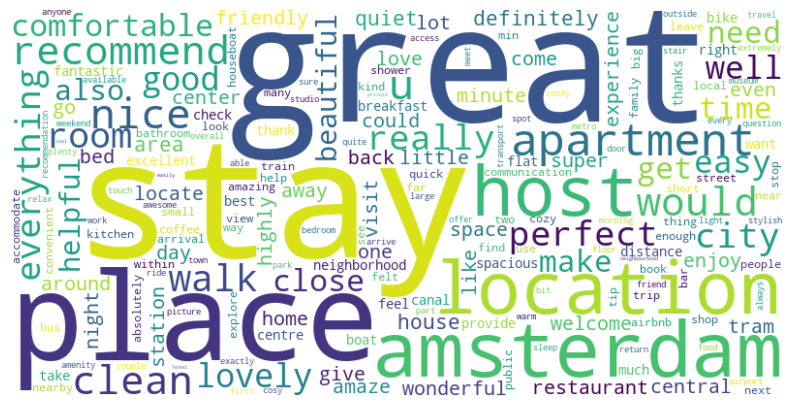

In [63]:
# Plot the word cloud
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

From the word cloud we can conclude that, the bigger the size of the word, the more frequent the word appears in the data. The following graph illustrates the word counts.

In [65]:
# Calculate word appearance frequency
freq_dist = FreqDist(all_comments_tokens)

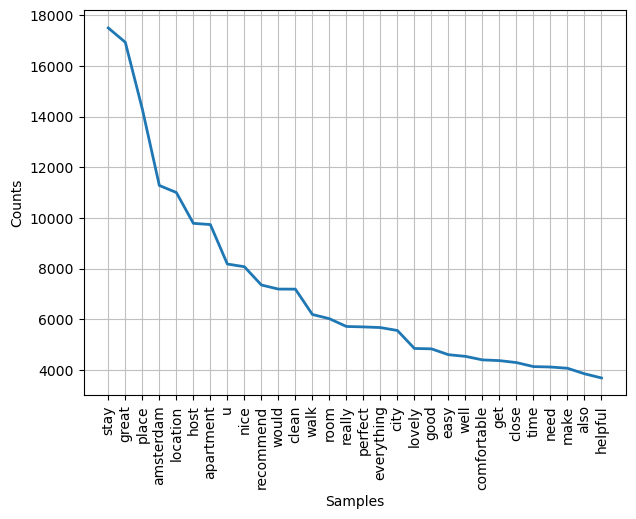

<Axes: xlabel='Samples', ylabel='Counts'>

In [66]:
# Plot the most common words
plt.figure(figsize=(7, 5))
freq_dist.plot(30, cumulative=False)

## Sentiment Analysis Modelling ##

In [68]:
clean_df.head()

,reviewer_name,comments,comments_cleaned,reviewer_name_cleaned,comments_tokens,reviewer_name_tokens
0,Kevin And Nicky,The Houseboat was truly fabulous. A great loca...,the houseboat was truly fabulous a great locat...,kevin and nicky,"[houseboat, truly, fabulous, great, location, ...","[kevin, nicky]"
1,Mathilde,The location is perfect and the boat is perfec...,the location is perfect and the boat is perfec...,mathilde,"[location, perfect, boat, perfect, derk, reall...",[mathilde]
2,Emily,We had such a lovely warm and comfortable stay...,we had such a lovely warm and comfortable stay...,emily,"[lovely, warm, comfortable, stay, derks, house...",[emily]
3,Jessica,Staying on the houseboat was one of the highli...,staying on the houseboat was one of the highli...,jessica,"[stay, houseboat, one, highlight, already, won...",[jessica]
4,Matthias,Great place to stay and discover the city. Esp...,great place to stay and discover the city espe...,matthias,"[great, place, stay, discover, city, especiall...",[matthias]


In [69]:
# Function to perform sentiment analysis
def sentiment_analysis(clean_df):
    def getSubjectivity(text):
        return TextBlob(text).sentiment.subjectivity

    def getPolarity(text):
        return TextBlob(text).sentiment.polarity

    def getAnalysis(score):
        if score < 0:
            return 'Negative'
        elif score == 0:
            return 'Neutral'
        else:
            return 'Positive'

    # Create three new columns 'TextBlob_Subjectivity', 'TextBlob_Polarity' and 'TextBlob_Analysis'
    clean_df['TextBlob_Subjectivity'] = clean_df['comments_cleaned'].apply(getSubjectivity)
    clean_df['TextBlob_Polarity'] = clean_df['comments_cleaned'].apply(getPolarity)
    clean_df['TextBlob_Analysis'] = clean_df['TextBlob_Polarity'].apply(getAnalysis)

    return clean_df

In [70]:
# Apply sentiment analysis using TextBlob and preview the results
clean_df = sentiment_analysis(clean_df)
clean_df

,reviewer_name,comments,comments_cleaned,reviewer_name_cleaned,comments_tokens,reviewer_name_tokens,TextBlob_Subjectivity,TextBlob_Polarity,TextBlob_Analysis
0,Kevin And Nicky,The Houseboat was truly fabulous. A great loca...,the houseboat was truly fabulous a great locat...,kevin and nicky,"[houseboat, truly, fabulous, great, location, ...","[kevin, nicky]",0.570880,0.341944,Positive
1,Mathilde,The location is perfect and the boat is perfec...,the location is perfect and the boat is perfec...,mathilde,"[location, perfect, boat, perfect, derk, reall...",[mathilde],0.680000,0.615000,Positive
2,Emily,We had such a lovely warm and comfortable stay...,we had such a lovely warm and comfortable stay...,emily,"[lovely, warm, comfortable, stay, derks, house...",[emily],0.530093,0.277037,Positive
3,Jessica,Staying on the houseboat was one of the highli...,staying on the houseboat was one of the highli...,jessica,"[stay, houseboat, one, highlight, already, won...",[jessica],0.575000,0.396296,Positive
4,Matthias,Great place to stay and discover the city. Esp...,great place to stay and discover the city espe...,matthias,"[great, place, stay, discover, city, especiall...",[matthias],0.665179,0.383705,Positive
...,...,...,...,...,...,...,...,...,...
28939,Sophie,The staff were really nice and attentive. The ...,the staff were really nice and attentive the s...,sophie,"[staff, really, nice, attentive, studio, perfe...",[sophie],0.920000,0.673333,Positive
28940,Terry,"This hotel was fantastic. Quality staff, rooms...",this hotel was fantastic quality staff rooms a...,terry,"[hotel, fantastic, quality, staff, room, ameni...",[terry],0.691667,0.305556,Positive
28941,Barry,"Great hotel, fantastic location",great hotel fantastic location,barry,"[great, hotel, fantastic, location]",[barry],0.825000,0.600000,Positive
28942,Christofer,Great place to stay,great place to stay,christofer,"[great, place, stay]",[christofer],0.750000,0.800000,Positive


## Visualization ##

In [72]:
# Count the occurrences of each sentiment
clean_df['TextBlob_Analysis'].value_counts()

TextBlob_Analysis
Positive    28309
Neutral       419
Negative      216
Name: count, dtype: int64

In [73]:
# Assign the occurrences of each sentiment into a variable for chart plotting
sentiment_counts = clean_df['TextBlob_Analysis'].value_counts()

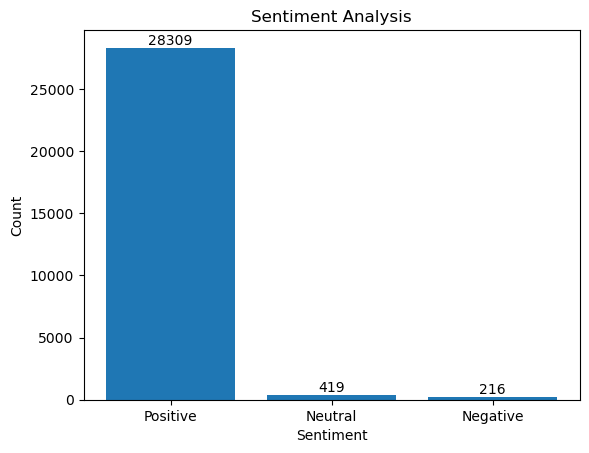

In [74]:
# Plot the sentiments
plt.bar(sentiment_counts.index, sentiment_counts.values)
labels = plt.bar_label(plt.gca().containers[0])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Analysis')

plt.show()

## Testing ##

In [76]:
# Adjust the index number for the comment's sentiment we wish to evaluate
test = TextBlob(clean_df['comments_cleaned'][1])

# Print the sentiment polarity result
print("Sentiment Polarity:", test.sentiment.polarity)

# Print the sentiment polarity result
print("Sentiment Subjectivity:", test.sentiment.subjectivity)

Sentiment Polarity: 0.615
Sentiment Subjectivity: 0.68


## Evaluation ##

In [78]:
# Define X and y
X = clean_df['comments_cleaned']
y = clean_df['TextBlob_Analysis']

In [79]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [80]:
# Vectorizing the text data (using TF-IDF vectorizer)
vectorizer = TfidfVectorizer(stop_words='english')
# vectorizer = TfidfVectorizer(max_features=20000)  # You can adjust max_features as needed
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

### Decision Tree ###

In [82]:
# Initialize and train and fit the Decision Tree model
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [83]:
# View the Decision Tree training score of the model
dt_train_score = dt.score(X_train, y_train)
print(f'Decision Tree Training Score: {dt_train_score:.4f}')

Decision Tree Training Score: 0.9999


In [84]:
# Make predictions
dt_y_pred = dt.predict(X_test)

In [85]:
# Evaluate the model
dt_accuracy = accuracy_score(y_test, dt_y_pred)
print("Accuracy:", dt_accuracy)
print("\nClassification Report:\n", classification_report(y_test, dt_y_pred))

Accuracy: 0.9777163586111591

Classification Report:
               precision    recall  f1-score   support

    Negative       0.19      0.15      0.17        48
     Neutral       0.64      0.62      0.63        85
    Positive       0.99      0.99      0.99      5656

    accuracy                           0.98      5789
   macro avg       0.61      0.59      0.60      5789
weighted avg       0.98      0.98      0.98      5789



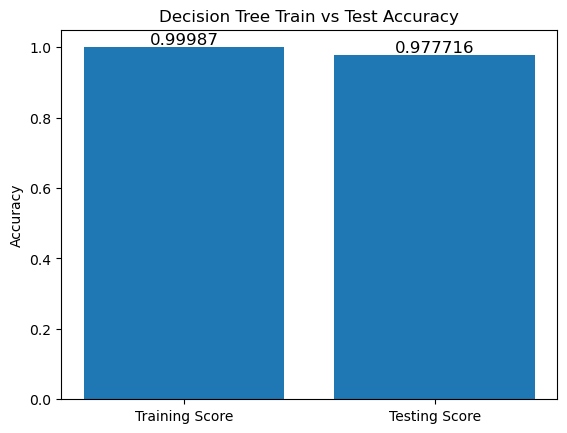

In [86]:
# Plot the Decision Tree training and testing scores
dt_scores = {'Training Score': dt_train_score, 'Testing Score': dt_accuracy}

# Create the plot
plt.bar(dt_scores.keys(), dt_scores.values())

# Add labels to each bar (using 'bar_label' function)
labels = plt.bar_label(plt.gca().containers[0])

# Set label formatting (optional)
plt.setp(labels, rotation=0, ha='center', fontsize=12)  # Rotate 0 degrees, center align, adjust font size

plt.ylabel('Accuracy')
plt.title('Decision Tree Train vs Test Accuracy')
plt.show()

In [87]:
### Perform Cross Validation Test ###

## Combine preprocessing with model training using a Pipeline to streamline the process
# Convert the text data into numerical format using TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')   # Initialize TfidfVectorizer
X_transformed = tfidf_vectorizer.fit_transform(X)   # Fit the TfidfVectorizer

# Define the pipeline
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words='english')),
    ('dt_scores', DecisionTreeClassifier(random_state=42))
])

# Perform cross-validation
dt_cv_scores = cross_val_score(pipeline, X, y, cv=10, error_score='raise')

# Output the results
print("Cross-Validation Scores:", dt_cv_scores)
print("Mean Accuracy:", np.mean(dt_cv_scores))
print("Standard Deviation of Accuracy:", np.std(dt_cv_scores))

Cross-Validation Scores: [0.98169257 0.9806563  0.9806563  0.98272884 0.97753974 0.97823082
 0.98099516 0.97373877 0.97131997 0.97719419]
Mean Accuracy: 0.9784752683474714
Standard Deviation of Accuracy: 0.0034715478729759486


### Support Vector Machine ###

In [89]:
# Training the SVM model
svm_model = SVC(kernel='linear')  # Using linear kernel for simplicity
svm_model.fit(X_train, y_train)

SVC(kernel='linear')

In [90]:
# View the SVM training score of the model
svm_train_score = svm_model.score(X_train, y_train)
print(f'SVM Training Score: {svm_train_score:.4f}')

SVM Training Score: 0.9899


In [91]:
# Predicting sentiment on the test set
svm_y_pred = svm_model.predict(X_test)

In [92]:
# Evaluating the model by viewing the testing score of the model
svm_accuracy = accuracy_score(y_test, svm_y_pred)
print(f'SVM Testing Score: {svm_accuracy:.4f}')

SVM Testing Score: 0.9855


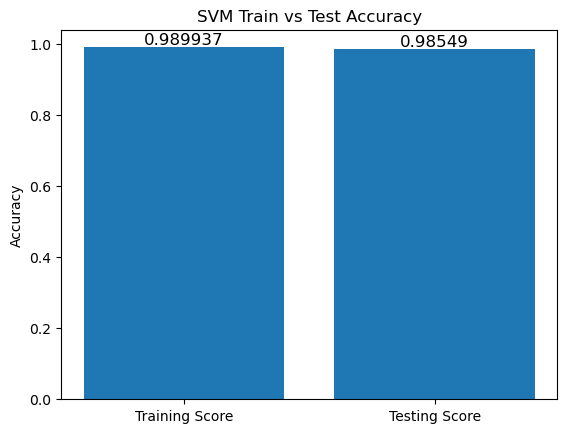

In [93]:
# Plot the SVM training and testing scores
svm_scores = {'Training Score': svm_train_score, 'Testing Score': svm_accuracy}

# Create the plot
plt.bar(svm_scores.keys(), svm_scores.values())

# Add labels to each bar (using 'bar_label' function)
labels = plt.bar_label(plt.gca().containers[0])

# Set label formatting (optional)
plt.setp(labels, rotation=0, ha='center', fontsize=12)  # Rotate 0 degrees, center align, adjust font size

plt.ylabel('Accuracy')
plt.title('SVM Train vs Test Accuracy')
plt.show()

In [94]:
### Perform Cross Validation Test ###

## Combine preprocessing with model training using a Pipeline to streamline the process
# Convert the text data into numerical format using TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')   # Initialize TfidfVectorizer
X_transformed = tfidf_vectorizer.fit_transform(X)   # Fit the TfidfVectorizer

# Define the pipeline
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words='english')),
    ('svm_scores', SVC(kernel='linear', random_state=42))
])

# Perform cross-validation
svm_cv_scores = cross_val_score(pipeline, X, y, cv=10, error_score='raise')

# Output the results
print("Cross-Validation Scores:", svm_cv_scores)
print("Mean Accuracy:", np.mean(svm_cv_scores))
print("Standard Deviation of Accuracy:", np.std(svm_cv_scores))

Cross-Validation Scores: [0.98963731 0.9851468  0.98549223 0.98618307 0.98686938 0.98652384
 0.98825155 0.98548721 0.98168625 0.98410504]
Mean Accuracy: 0.9859382702345274
Standard Deviation of Accuracy: 0.002068167863807216


### Logistic Regression ###

In [96]:
# Initialize, train and fit the Logistic Regression model
logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)

LogisticRegression()

In [97]:
# View the LogReg training score of the model
logreg_train_score = logreg_model.score(X_train, y_train)
print(f'Logistic Regression Training Score: {logreg_train_score:.4f}')

Logistic Regression Training Score: 0.9860


In [98]:
# Make predictions
logreg_y_pred = logreg_model.predict(X_test)

In [99]:
# Calculate LogReg accuracy
logreg_accuracy = accuracy_score(y_test, logreg_y_pred)
print(f'Logistic Regression Testing Score: {logreg_accuracy:.4f}')

Logistic Regression Testing Score: 0.9853


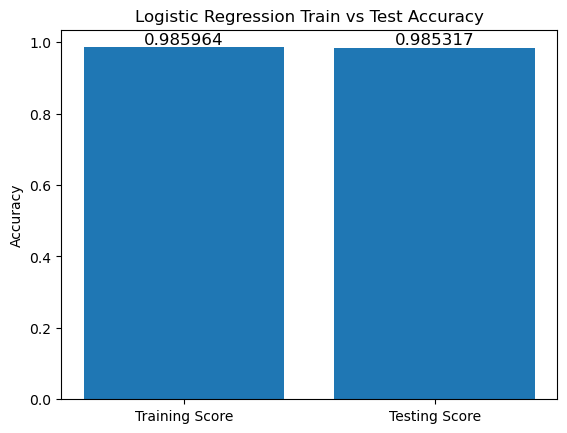

In [100]:
# Plot the LogReg training and testing scores
logreg_scores = {'Training Score': logreg_train_score, 'Testing Score': logreg_accuracy}

# Create the plot
plt.bar(logreg_scores.keys(), logreg_scores.values())

# Add labels to each bar (using 'bar_label' function)
labels = plt.bar_label(plt.gca().containers[0])

# Set label formatting (optional)
plt.setp(labels, rotation=0, ha='center', fontsize=12)  # Rotate 0 degrees, center align, adjust font size

plt.ylabel('Accuracy')
plt.title('Logistic Regression Train vs Test Accuracy')
plt.show()

In [101]:
### Perform Cross Validation Test ###

## Combine preprocessing with model training using a Pipeline to streamline the process
# Convert the text data into numerical format using TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')   # Initialize TfidfVectorizer
X_transformed = tfidf_vectorizer.fit_transform(X)   # Fit the TfidfVectorizer

# Define the pipeline
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words='english')),
    ('logreg_scores', LogisticRegression())
])

# Perform cross-validation
logreg_cv_scores = cross_val_score(pipeline, X, y, cv=10, error_score='raise')

# Output the results
print("Cross-Validation Scores:", logreg_cv_scores)
print("Mean Accuracy:", np.mean(logreg_cv_scores))
print("Standard Deviation of Accuracy:", np.std(logreg_cv_scores))

Cross-Validation Scores: [0.98963731 0.98480138 0.98549223 0.98618307 0.98686938 0.9861783
 0.98790601 0.98514167 0.98168625 0.98410504]
Mean Accuracy: 0.985800065169674
Standard Deviation of Accuracy: 0.0020473112781121366


### Multinomial Naive Bayes ###

In [103]:
# Initialize, train and fit the Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

MultinomialNB()

In [104]:
nb_train_score = nb_model.score(X_train, y_train)
print(f'Logistic Regression Training Score: {nb_train_score:.4f}')

Logistic Regression Training Score: 0.9858


In [105]:
# Predict
nb_y_pred = nb_model.predict(X_test)

# Evaluate
nb_accuracy = accuracy_score(y_test, nb_y_pred)

print("Accuracy:", nb_accuracy)
print("\nClassification Report:\n", classification_report(y_test, nb_y_pred))

Accuracy: 0.9851442390741061

Classification Report:
               precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        48
     Neutral       1.00      0.55      0.71        85
    Positive       0.99      1.00      0.99      5656

    accuracy                           0.99      5789
   macro avg       0.66      0.52      0.57      5789
weighted avg       0.98      0.99      0.98      5789



C:\Users\Daniel\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Daniel\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Daniel\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


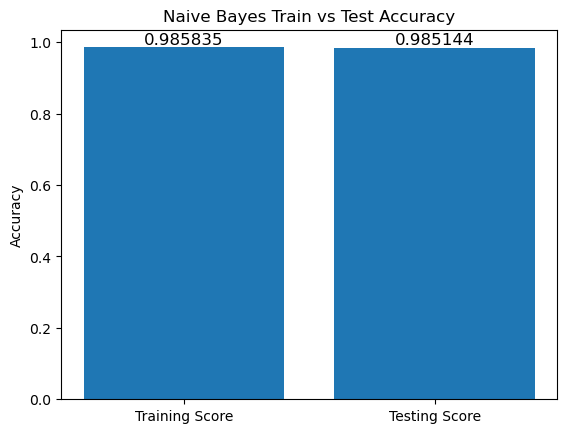

In [106]:
# Plot the Naive Bayes training and testing scores
nb_scores = {'Training Score': nb_train_score, 'Testing Score': nb_accuracy}

# Create the plot
plt.bar(nb_scores.keys(), nb_scores.values())

# Add labels to each bar (using 'bar_label' function)
labels = plt.bar_label(plt.gca().containers[0])

# Set label formatting (optional)
plt.setp(labels, rotation=0, ha='center', fontsize=12)  # Rotate 0 degrees, center align, adjust font size

plt.ylabel('Accuracy')
plt.title('Naive Bayes Train vs Test Accuracy')
plt.show()

In [107]:
### Perform Cross Validation Test ###

## Combine preprocessing with model training using a Pipeline to streamline the process
# Convert the text data into numerical format using TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')   # Initialize TfidfVectorizer
X_transformed = tfidf_vectorizer.fit_transform(X)   # Fit the TfidfVectorizer

# Define the pipeline
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words='english')),
    ('nb_scores', MultinomialNB())
])

# Perform cross-validation
nb_cv_scores = cross_val_score(pipeline, X, y, cv=10, error_score='raise')

# Output the results
print("Cross-Validation Scores:", nb_cv_scores)
print("Mean Accuracy:", np.mean(nb_cv_scores))
print("Standard Deviation of Accuracy:", np.std(nb_cv_scores))

Cross-Validation Scores: [0.98963731 0.98480138 0.98549223 0.98583765 0.98652384 0.98583276
 0.98790601 0.98514167 0.98168625 0.9837595 ]
Mean Accuracy: 0.9856618601048204
Standard Deviation of Accuracy: 0.002052017634989112


### Random Forests ###

In [109]:
# Initialize, train and fit the Random Forests model
rf_classifier = RandomForestClassifier(n_estimators=777, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=777, random_state=42)

In [110]:
rf_train_score = rf_classifier.score(X_train, y_train)
print(f'Random Forests Training Score: {rf_train_score:.4f}')

Random Forests Training Score: 0.9999


In [111]:
# Predictions
rf_y_pred = rf_classifier.predict(X_test)

In [112]:
# Calculate Random Forests accuracy
rf_accuracy = accuracy_score(y_test, rf_y_pred)
print(f'Random Forests Testing Score: {rf_accuracy:.4f}')

Random Forests Testing Score: 0.9860


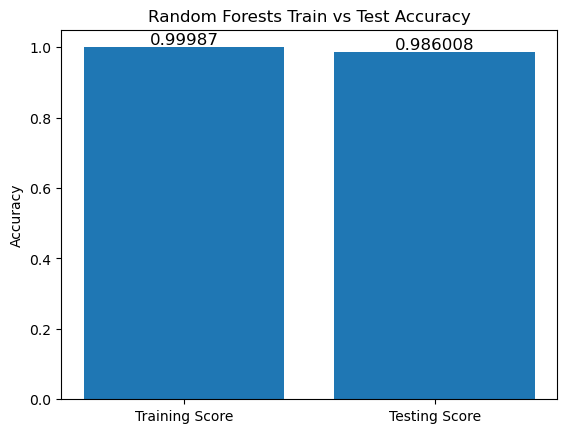

In [113]:
# Plot the LogReg training and testing scores
rf_scores = {'Training Score': rf_train_score, 'Testing Score': rf_accuracy}

# Create the plot
plt.bar(rf_scores.keys(), rf_scores.values())

# Add labels to each bar (using 'bar_label' function)
labels = plt.bar_label(plt.gca().containers[0])

# Set label formatting (optional)
plt.setp(labels, rotation=0, ha='center', fontsize=12)  # Rotate 0 degrees, center align, adjust font size

plt.ylabel('Accuracy')
plt.title('Random Forests Train vs Test Accuracy')
plt.show()

In [114]:
## This code snippet uses grid search to find the optimal number of trees based on cross-validation performance

# Define the parameter grid
param_grid = {'n_estimators': [100, 200, 500, 1000]}

# Create the model
rf = RandomForestClassifier()

# Setup the grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Get the best number of trees
best_n_estimators = grid_search.best_params_['n_estimators']
print(f"Optimal number of trees: {best_n_estimators}")

Optimal number of trees: 500


In [215]:
### Perform Cross Validation Test ###

## Combine preprocessing with model training using a Pipeline to streamline the process
# Convert the text data into numerical format using TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')   # Initialize TfidfVectorizer
X_transformed = tfidf_vectorizer.fit_transform(X)   # Fit the TfidfVectorizer

# Define the pipeline
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words='english')),
    ('classifier', RandomForestClassifier(n_estimators=500, random_state=42))
])

# Perform cross-validation
rf_cv_scores = cross_val_score(pipeline, X, y, cv=10, error_score='raise')

# Output the results
print("Cross-Validation Scores:", rf_cv_scores)
print("Mean Accuracy:", np.mean(rf_cv_scores))
print("Standard Deviation of Accuracy:", np.std(rf_cv_scores))

Cross-Validation Scores: [0.98963731 0.98549223 0.98618307 0.9865285  0.98721493 0.98583276
 0.98825155 0.98514167 0.98272287 0.98410504]
Mean Accuracy: 0.9861109937420404
Standard Deviation of Accuracy: 0.0018793111233397536


In [222]:
# Summary of cross-validation results
results = {
    'Decision Tree': {
        'mean_accuracy': np.mean(dt_cv_scores),
        'std_dev_accuracy': np.std(dt_cv_scores)
    },
    'SVM': {
        'mean_accuracy': np.mean(svm_cv_scores),
        'std_dev_accuracy': np.std(svm_cv_scores)
    },
    'Logistic Regression': {
        'mean_accuracy': np.mean(logreg_cv_scores),
        'std_dev_accuracy': np.std(logreg_cv_scores)
    },
    'Multinomial Naive Bayes': {
        'mean_accuracy': np.mean(nb_cv_scores),
        'std_dev_accuracy': np.std(nb_cv_scores)
    },
    'Random Forest': {
        'mean_accuracy': np.mean(rf_cv_scores),
        'std_dev_accuracy': np.std(rf_cv_scores)
    }
}

# Print the results of all the models
for model, metrics in results.items():
    print(f"{model}:")
    print(f"Mean Accuracy: {metrics['mean_accuracy']:.4f}")
    print(f"Standard Deviation: {metrics['std_dev_accuracy']:.4f}")

Decision Tree:
Mean Accuracy: 0.9785
Standard Deviation: 0.0035
SVM:
Mean Accuracy: 0.9859
Standard Deviation: 0.0021
Logistic Regression:
Mean Accuracy: 0.9858
Standard Deviation: 0.0020
Multinomial Naive Bayes:
Mean Accuracy: 0.9857
Standard Deviation: 0.0021
Random Forest:
Mean Accuracy: 0.9861
Standard Deviation: 0.0019


In [223]:
# Extracting the negative reviews
negative_sentiments_df = clean_df[clean_df['TextBlob_Analysis'] == 'Negative']

# Reset the dataset index to start from 0, then modify the index to start from 1
negative_sentiments_df.reset_index(drop=True, inplace=True)
negative_sentiments_df.index = negative_sentiments_df.index + 1

# Display the filtered DataFrame
print(negative_sentiments_df['comments_cleaned'].head(10))

# Export the filtered DataFrame to a CSV file
negative_sentiments_df.to_csv('negative_sentiments.csv', index=False)

1     our first time using airbb so we were not sure...
2     unfortunately i was not met at the place when ...
3     alexs house is extremely central and the bed i...
4     the apartment is cosy and pretty although it w...
5     we stayed on a saturday night and it was quite...
6     you know that seinfeld episode where jerry rea...
7                             clean a few things broken
8     he helped in carrying the suitcases up the nar...
9     a cosy little flat that i recommend with no he...
10    the place is really nice and its in a strategi...
Name: comments_cleaned, dtype: object
